In [10]:
import os
from typing import Optional, Dict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy

from pandas import DataFrame

pd.set_option('max_columns', None)
pd.set_option('max_rows', None)

class Metric:
    name: str
    abbreviation: str
    unit: Optional[str]

    def __init__(self, name: str, abbreviation: str, unit: Optional[str]) -> None:
        self.name = name
        self.abbreviation = abbreviation
        self.unit = unit

    def __str__(self) -> str:
        base = f"{self.name} ({self.abbreviation})"

        if self.unit:
            return f"{base} [{self.unit}]"
        else:
            return base

OUT_DIR = "output"

if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

APPLICATIONS = {
    "postgresql-ha": "PostgreSQL",
    "redis": "Redis",
    # "redis-cluster": "Redis Cluster,
}
EXPERIMENTS = {
    "ct": "Control Test",
    "pd": "Perturbation Disabled",
    "vb": "Vary Build",
    "vp": "Vary Patch",
    "vm": "Vary Minor",
}
METRICS: Dict[str, Metric] = {
    "time_to_initialize": Metric(
        name="Time to Complete Initialization",
        abbreviation="TCI",
        unit="s",
        ),
    "time_to_first_request": Metric(
        name="Time to First Request",
        abbreviation="TFR",
        unit="s",
    ),
    "time_to_all_requests": Metric(
        name="Time to All Containers Handle Requests",
        abbreviation="TACHR",
        unit="s",
    ),
    "restarts": Metric(
        name="Amount of Container Restarts",
        abbreviation="ACR",
        unit=None,
    ),
}

In [11]:
try:
    # Use the current file as the base-path
    base_path = os.path.dirname(__file__)
except NameError:
    # Fall back to the current directory if it is not available,
    # is it means that we are in interactive mode.
    base_path = "."


# Read all datafiles as separate DataFrames
dfs = {
    (application_name, experiment): pd.read_json(path, lines=True)
    if os.path.isfile(path := os.path.join(base_path, "..", "results", f"{experiment}_{application}.jsonl")) else None
    for experiment in EXPERIMENTS.keys()
    for application, application_name in APPLICATIONS.items()
}

# Combine all DataFrames
df = pd.concat(dfs, names=["Application", "experiment"])

# Adds the experiment and application index as a column
df.reset_index(level=[0, 1], inplace=True)

# Adds a human readable experiment name column
df["experiment_name"] = df["experiment"].apply(lambda x: EXPERIMENTS[x])


# All Raw Data

In [12]:
# Display the data loaded
df

,Application,experiment,start_time,time_to_initialize,time_to_first_request,time_to_all_requests,restarts,end_time,experiment_name
0,PostgreSQL,ct,2020-08-10 14:05:56.242291927,78.602810,45.747801,70.021016,0,2020-08-10 14:07:15.298298836,Control Test
1,PostgreSQL,ct,2020-08-10 14:14:43.314725161,45.677756,27.764674,34.111991,0,2020-08-10 14:15:29.429429054,Control Test
2,PostgreSQL,ct,2020-08-10 14:22:17.197078943,68.845743,42.068355,68.319220,0,2020-08-10 14:23:26.447458982,Control Test
3,PostgreSQL,ct,2020-08-10 14:29:47.296878099,65.700319,38.411755,61.599261,0,2020-08-10 14:30:53.454533815,Control Test
4,PostgreSQL,ct,2020-08-10 14:37:04.917234898,53.025109,24.400544,34.525423,0,2020-08-10 14:37:58.422300816,Control Test
5,PostgreSQL,ct,2020-08-10 14:45:00.511804818,59.683125,23.833006,32.322419,0,2020-08-10 14:46:00.655070066,Control Test
6,PostgreSQL,ct,2020-08-10 14:53:26.960787058,57.069379,27.461419,37.550996,0,2020-08-10 14:54:24.504987955,Control Test
7,PostgreSQL,ct,2020-08-10 15:10:44.283836842,65.758005,25.795390,38.214952,0,2020-08-10 15:11:50.535685062,Control Test
8,PostgreSQL,ct,2020-08-10 15:18:39.908933878,41.761491,26.440772,32.285831,0,2020-08-10 15:19:22.291574001,Control Test
9,PostgreSQL,ct,2020-08-10 15:25:34.384053946,42.127745,24.815127,35.697144,0,2020-08-10 15:26:16.970113993,Control Test


In [13]:
df.groupby(["experiment_name", "Application"])\
    [["time_to_initialize", "restarts"]]\
    .mean()\
    .round(2)

time_to_initialize  restarts
experiment_name       Application                              
Control Test          PostgreSQL                57.19      0.00
                      Redis                     36.72      0.00
Perturbation Disabled PostgreSQL                57.15      0.00
                      Redis                     39.67      0.00
Vary Build            PostgreSQL                64.17      0.00
                      Redis                     42.76      0.00
Vary Minor            PostgreSQL               514.18     10.47
Vary Patch            PostgreSQL               134.51      3.87
                      Redis                     38.23      0.00

# Plots

In [14]:
def save_plot(name: str):
    for file_type in ["pdf", "png", "jpg", "svg"]:
        plt.savefig(os.path.join(OUT_DIR, f"{name}.{file_type}"),
                    transparent=True,
                    bbox_inches='tight'
                    )

def show_plot(data: DataFrame, x: str, y: str, xlabel: str, ylabel: str, hue: Optional[str] = None) -> None:
    f, ax = plt.subplots(figsize=(12, 3))

    sns.boxplot(data=data,
                x=x,
                y=y,
                hue=hue,
                )

    sns.swarmplot(data=data,
                  x=x,
                  y=y,
                  size=3,
                  hue=hue,
                  alpha=0.5,
                  )

    sns.set(style="ticks")

    ax.xaxis.grid(True)
    ax.set_xlim(xmin=-1,)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

## Control Test vs. Perturbation Disabled

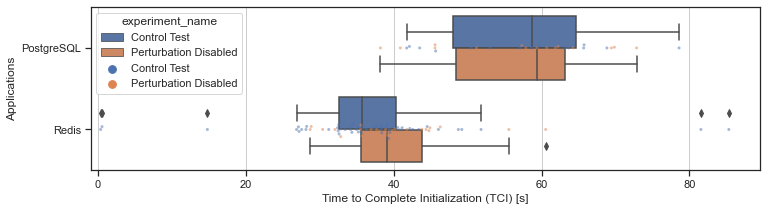

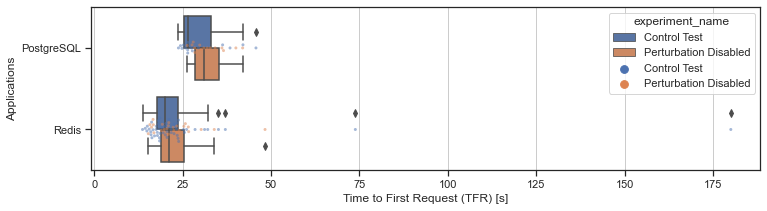

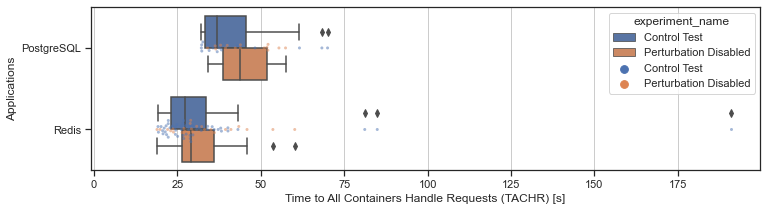

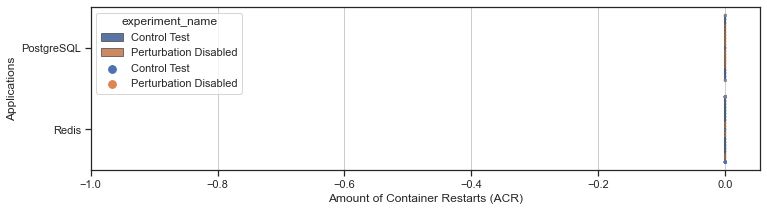

In [15]:
for metric in METRICS.keys():
    show_plot(data=df[(df.experiment.isin(["ct", "pd"]))],
              x=metric,
              y="Application",
              xlabel=str(METRICS[metric]),
              ylabel="Applications",
              hue="experiment_name"
              )
    save_plot(f"ct_vs_pd-{metric}")

## Distributions for each Metric

In [ ]:
for metric in METRICS.keys():
    show_plot(data=df,
              x=metric,
              y="experiment_name",
              xlabel=str(METRICS[metric]),
              ylabel="Experiment",
              hue="Application"
              )
    save_plot(f"box_and_scatter_plot-{metric}")

# Statistical Significance

## Control Test vs. Perturbation Disabled

### By Metric & Application

Here we calculate the p-value for the hypothesis that

In [ ]:
pvalues = pd.DataFrame(({
    "p-Value": scipy.stats.ttest_ind(*(df[(df.experiment == experiment) & (df.Application == application)][metric]
                                        for experiment in ("ct", "pd",)
                                       ),
                                      equal_var=True
                                      ).pvalue,
    "Metric": str(METRICS[metric]),
    "Application": application,
    }
for metric in filter(lambda x: x != "restarts", METRICS.keys())
for application in ("PostgreSQL", "Redis")
))

pvalues.pivot("Metric", "Application")

### Combined
These p-values can be combined using the Fisher's method, which yields a combined probabilty of:

In [ ]:
(_, combined_pvalue) = scipy.stats.combine_pvalues(pvalues["p-Value"])

combined_pvalue